# Evaluation 
In this notebook we are loading our pretrained self supervised model and fine-tuning on different noisy datasets to check the robustness of the represenatations being learned.

### 1. Load libraries

In [1]:
import numpy as np
from models import transformer_autoencoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,f1_score,average_precision_score,accuracy_score
import lightning as L
import pandas as pd
import torch
from datamodules.datasets import tabular_dataset
import matplotlib.pyplot as plt

### 2. Load Data

Create a list to read different noisy datasets

In [2]:
msk_list = [str(i) for i in range(20,60,10)]
noise_list = [str(i) for i in range(0,60,10)]
noise_list

['0', '10', '20', '30', '40', '50']

In [3]:
noised_base_pth = "../data/sample/train/scaled/train_flipped_labels_"
test = pd.read_csv("../data/sample/test/scaled/test_scaled.csv")
test_base_pth = "../data/sample/test/scaled/test_scaled.csv"
denoised_list =[]
noised_list=[]
for i in range(len(noise_list)):
    df = pd.read_csv(noised_base_pth+noise_list[i]+".csv")
    df.drop('label', axis=1, inplace=True)
    df.rename(columns = {'label_flip' : 'label'}, inplace=True)
    noised_list.append(df)
len(noised_list)


6

In [27]:
noised_list[2]

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,label
0,-0.302425,0.394286,0.308880,-0.186893,0.729531,-0.388732,0.625353,-0.214662,0.714145,-0.770483,...,0.823959,0.028582,-0.305572,0.609784,-0.721062,0.054898,0.248525,-0.333679,-0.441656,1
1,-1.111643,-0.171171,-0.227577,-0.186893,0.729531,-0.388732,-1.335923,-0.214662,0.714145,-0.261215,...,0.823959,1.146147,3.272553,0.609784,1.386844,-1.455677,0.984227,-0.019559,1.824984,1
2,-0.302425,1.242472,-0.522885,-0.186893,0.729531,-0.388732,0.625353,-0.214662,0.714145,-0.814982,...,0.823959,-1.088984,-0.305572,-1.639926,-0.721062,0.594389,-0.695394,0.210385,0.540261,1
3,1.316011,1.101108,1.116530,-0.186893,0.729531,-0.388732,0.625353,4.658484,0.714145,0.453244,...,0.823959,1.146147,-0.305572,-1.639926,-0.721062,-0.769052,-0.757859,-0.553358,0.337410,1
4,-1.111643,0.394286,5.140345,-0.186893,0.729531,-0.388732,0.625353,-0.214662,-1.400275,-0.805093,...,-1.213652,1.146147,-0.305572,-1.639926,1.386844,1.800888,0.068070,1.142479,-0.162368,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1.316011,-0.029807,0.046172,-0.186893,0.729531,-0.388732,0.625353,-0.214662,0.714145,1.914300,...,-1.213652,0.028582,-0.305572,0.609784,1.386844,2.762163,1.518652,0.754449,-0.306422,0
39996,-0.302425,-1.019357,-0.541016,-0.186893,0.729531,-0.388732,0.625353,-0.214662,-1.400275,-0.814982,...,-1.213652,-1.088984,-0.305572,-1.639926,-0.721062,0.094134,0.609436,-0.448651,1.037099,0
39997,-1.111643,0.818379,0.250143,-0.186893,0.729531,-0.388732,0.625353,-0.214662,0.714145,-0.814982,...,0.823959,-1.088984,-0.305572,0.609784,-0.721062,-0.082427,1.594999,1.101418,-0.121210,0
39998,-1.111643,-0.453900,-1.961787,-0.186893,-1.370745,-0.388732,0.625353,-0.214662,0.714145,-0.814982,...,0.823959,-1.088984,-0.305572,0.609784,1.386844,0.319739,0.047249,-1.179545,-0.115330,1


### 3. Load Pre-trained model

In [5]:
pretrain_base_pth = "../outputs/pretrainlocal/mask_50/epoch=68.ckpt"
pretrained=transformer_autoencoder.TransformerAutoEncoder.load_from_checkpoint(pretrain_base_pth)
pretrained.eval()

TransformerAutoEncoder(
  (masker): Masker()
  (position_embedding): PositionalEmbedding(
    (position_embedding): Embedding(21, 127)
  )
  (encoder): TransformerEncoder(
    (encoder_blocks): ModuleList(
      (0-4): 5 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (feedforward): PositionwiseFeedForward(
          (linear_in): Linear(in_features=128, out_features=128, bias=True)
          (linear_out): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layernorm_attention): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layernorm_feedforward): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): TransformerDecoder(
    (decoder_blocks): ModuleList(
      (0-2): 3 x TransformerBl

### 4. Fine-tuning

In [4]:
features_numerical = ['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20']
features_categorical = []
name_labels = ['label']

#### 4.1. Masking Rate = 50%

In [62]:
# Define the device (CPU, GPU, or MPS)
device = "cpu" #torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

msk_rate = "50"   
df_data = []

for i in range(len(noised_list)):
    x_raw = tabular_dataset.TabularDataset(noised_base_pth + noise_list[i] + ".csv", name_labels, features_numerical, features_categorical)
    test_raw = tabular_dataset.TabularDataset(test_base_pth, name_labels, features_numerical, features_categorical)
    
    auc = f1 = ap = accuracy = 0
    cnt = 0
   
    train_generator = torch.utils.data.DataLoader(x_raw, batch_size=128)
    test_generator = torch.utils.data.DataLoader(test_raw, batch_size=128)
    
    # Initialize tensors on the correct device
    emb_total = torch.Tensor().to(device)
    lab_total = torch.Tensor().to(device)
    emb_total_test = torch.Tensor().to(device)
    lab_total_test = torch.Tensor().to(device)
    
    for batch in iter(train_generator):
        batch_test = next(iter(test_generator))
        cnt += 1
        
        with torch.no_grad():
            # Move tensors to the correct device
            x = batch[0].to(device)
            labels = batch[1].to(device)
            x_test = batch_test[0].to(device)
            labels_test = batch_test[1].to(device)
            
            # Obtain embeddings
            emb_per_batch = pretrained(x, 0).to(device)
            emb_per_batch = emb_per_batch.view(emb_per_batch.size(0), -1) # properly flattening

            emb_per_batch_test = pretrained(x_test, 0).to(device)
            emb_per_batch_test = emb_per_batch_test.view(emb_per_batch_test.size(0), -1)

            
            # Concatenate embeddings and labels
            emb_total = torch.cat([emb_total, emb_per_batch])
            lab_total = torch.cat([lab_total, labels])
            emb_total_test = torch.cat([emb_total_test, emb_per_batch_test])
            lab_total_test = torch.cat([lab_total_test, labels_test])
    

    # Reshape embeddings to 2D
    emb_total = emb_total.view(-1, emb_total.size(-1)).cpu().numpy()
    lab_total = lab_total.view(-1).cpu().numpy()
    emb_total_test = emb_total_test.view(-1, emb_total_test.size(-1)).cpu().numpy()
    lab_total_test = lab_total_test.view(-1).cpu().numpy()


    # Train logistic regression and evaluate
    reg = LogisticRegression().fit(emb_total, lab_total)    
    pred = reg.predict(emb_total_test)
        
    auc_batch = roc_auc_score(lab_total_test, pred)
    f1_batch = f1_score(lab_total_test, pred)
    ap_batch = average_precision_score(lab_total_test, pred)
    accuracy_batch = accuracy_score(lab_total_test, pred)
        
    auc += auc_batch
    f1 += f1_batch
    ap += ap_batch
    accuracy += accuracy_batch
        
    print("-----" + noise_list[i] + "% noise" + "-----")
    print("AUC: " + str(auc))
    print("F1: " + str(f1))
    print("AP: " + str(ap))
    print("Accuracy: " + str(accuracy))
    
    df_data.append([msk_rate, noise_list[i], auc, f1, ap, accuracy])
    
df = pd.DataFrame(df_data, columns=["Masking", "Noise", "AUC", "F1", "AP", "Accuracy"])


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----0% noise-----
AUC: 0.5314009661835748
F1: 0.20833333333333334
AP: 0.30005787037037035
Accuracy: 0.703125


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----10% noise-----
AUC: 0.5875603864734299
F1: 0.3728813559322034
AP: 0.3414477657004831
Accuracy: 0.7109375


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----20% noise-----
AUC: 0.6352657004830917
F1: 0.47058823529411764
AP: 0.3784722222222222
Accuracy: 0.71875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----30% noise-----
AUC: 0.7083333333333334
F1: 0.5783132530120482
AP: 0.43417553191489355
Accuracy: 0.7265625


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----40% noise-----
AUC: 0.7155797101449276
F1: 0.5825242718446602
AP: 0.420009328358209
Accuracy: 0.6640625
-----50% noise-----
AUC: 0.6871980676328502
F1: 0.5555555555555556
AP: 0.38589891975308643
Accuracy: 0.5625


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 50%

In [64]:
df.head(10)

,Masking,Noise,AUC,F1,AP,Accuracy
0,50,0,0.531401,0.208333,0.300058,0.703125
1,50,10,0.587560,0.372881,0.341448,0.710938
2,50,20,0.635266,0.470588,0.378472,0.718750
3,50,30,0.708333,0.578313,0.434176,0.726562
4,50,40,0.715580,0.582524,0.420009,0.664062
5,50,50,0.687198,0.555556,0.385899,0.562500


In [65]:
accuracies = df.Accuracy.to_list()
f1_scores = df.F1.to_list()

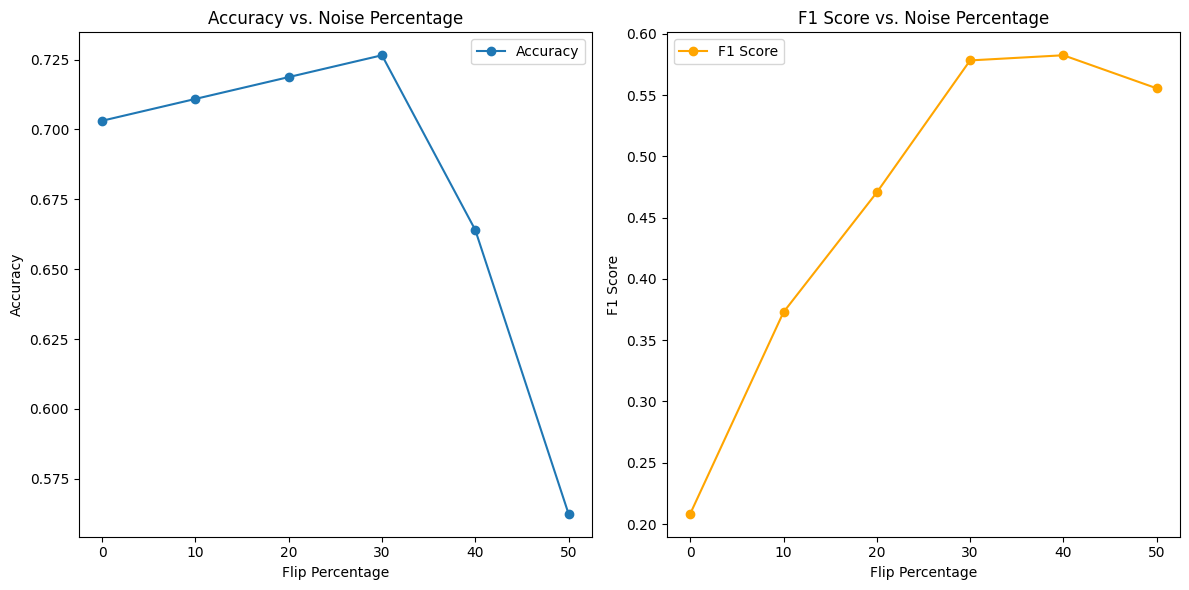

In [69]:
# Plot the accuracy and F1 scores
percentages = [0,10, 20, 30, 40, 50]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(percentages, accuracies, marker='o', label='Accuracy')
plt.xlabel('Flip Percentage')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Percentage')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(percentages, f1_scores, marker='o', label='F1 Score', color='orange')
plt.xlabel('Flip Percentage')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Noise Percentage')
plt.legend()

plt.tight_layout()
plt.show()

#### 4.1. Masking Rate = 50% - with lower poistional embeddings dimensions

In [70]:
pretrain_base_pth = "../outputs/pretrainlocal/mask_50_1/epoch=80.ckpt"
pretrained=transformer_autoencoder.TransformerAutoEncoder.load_from_checkpoint(pretrain_base_pth)
pretrained.eval()

TransformerAutoEncoder(
  (masker): Masker()
  (position_embedding): PositionalEmbedding(
    (position_embedding): Embedding(21, 127)
  )
  (encoder): TransformerEncoder(
    (encoder_blocks): ModuleList(
      (0-4): 5 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (feedforward): PositionwiseFeedForward(
          (linear_in): Linear(in_features=128, out_features=128, bias=True)
          (linear_out): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layernorm_attention): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layernorm_feedforward): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): TransformerDecoder(
    (decoder_blocks): ModuleList(
      (0-2): 3 x TransformerBl

In [71]:
# Define the device (CPU, GPU, or MPS)
device = "cpu" #torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

msk_rate = "50"   
df_data = []

for i in range(len(noised_list)):
    x_raw = tabular_dataset.TabularDataset(noised_base_pth + noise_list[i] + ".csv", name_labels, features_numerical, features_categorical)
    test_raw = tabular_dataset.TabularDataset(test_base_pth, name_labels, features_numerical, features_categorical)
    
    auc = f1 = ap = accuracy = 0
    cnt = 0
   
    train_generator = torch.utils.data.DataLoader(x_raw, batch_size=128)
    test_generator = torch.utils.data.DataLoader(test_raw, batch_size=128)
    
    # Initialize tensors on the correct device
    emb_total = torch.Tensor().to(device)
    lab_total = torch.Tensor().to(device)
    emb_total_test = torch.Tensor().to(device)
    lab_total_test = torch.Tensor().to(device)
    
    for batch in iter(train_generator):
        batch_test = next(iter(test_generator))
        cnt += 1
        
        with torch.no_grad():
            # Move tensors to the correct device
            x = batch[0].to(device)
            labels = batch[1].to(device)
            x_test = batch_test[0].to(device)
            labels_test = batch_test[1].to(device)
            
            # Obtain embeddings
            emb_per_batch = pretrained(x, 0).to(device)
            emb_per_batch = emb_per_batch.view(emb_per_batch.size(0), -1) # properly flattening

            emb_per_batch_test = pretrained(x_test, 0).to(device)
            emb_per_batch_test = emb_per_batch_test.view(emb_per_batch_test.size(0), -1)

            
            # Concatenate embeddings and labels
            emb_total = torch.cat([emb_total, emb_per_batch])
            lab_total = torch.cat([lab_total, labels])
            emb_total_test = torch.cat([emb_total_test, emb_per_batch_test])
            lab_total_test = torch.cat([lab_total_test, labels_test])
    

    # Reshape embeddings to 2D
    emb_total = emb_total.view(-1, emb_total.size(-1)).cpu().numpy()
    lab_total = lab_total.view(-1).cpu().numpy()
    emb_total_test = emb_total_test.view(-1, emb_total_test.size(-1)).cpu().numpy()
    lab_total_test = lab_total_test.view(-1).cpu().numpy()


    # Train logistic regression and evaluate
    reg = LogisticRegression().fit(emb_total, lab_total)    
    pred = reg.predict(emb_total_test)
        
    auc_batch = roc_auc_score(lab_total_test, pred)
    f1_batch = f1_score(lab_total_test, pred)
    ap_batch = average_precision_score(lab_total_test, pred)
    accuracy_batch = accuracy_score(lab_total_test, pred)
        
    auc += auc_batch
    f1 += f1_batch
    ap += ap_batch
    accuracy += accuracy_batch
        
    print("-----" + noise_list[i] + "% noise" + "-----")
    print("AUC: " + str(auc))
    print("F1: " + str(f1))
    print("AP: " + str(ap))
    print("Accuracy: " + str(accuracy))
    
    df_data.append([msk_rate, noise_list[i], auc, f1, ap, accuracy])
    
df = pd.DataFrame(df_data, columns=["Masking", "Noise", "AUC", "F1", "AP", "Accuracy"])

/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----0% noise-----
AUC: 0.5646135265700483
F1: 0.28571428571428575
AP: 0.3312633547008547
Accuracy: 0.7265625


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----10% noise-----
AUC: 0.5984299516908212
F1: 0.3859649122807018
AP: 0.3553654100529101
Accuracy: 0.7265625


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----20% noise-----
AUC: 0.6105072463768116
F1: 0.43478260869565216
AP: 0.35345643939393934
Accuracy: 0.6953125


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----30% noise-----
AUC: 0.7028985507246377
F1: 0.5714285714285715
AP: 0.4270833333333333
Accuracy: 0.71875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----40% noise-----
AUC: 0.7101449275362318
F1: 0.576923076923077
AP: 0.41452205882352944
Accuracy: 0.65625
-----50% noise-----
AUC: 0.6733091787439613
F1: 0.5439999999999999
AP: 0.37642400124843944
Accuracy: 0.5546875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 50% - 2

In [72]:
df.head(10)

,Masking,Noise,AUC,F1,AP,Accuracy
0,50,0,0.564614,0.285714,0.331263,0.726562
1,50,10,0.598430,0.385965,0.355365,0.726562
2,50,20,0.610507,0.434783,0.353456,0.695312
3,50,30,0.702899,0.571429,0.427083,0.718750
4,50,40,0.710145,0.576923,0.414522,0.656250
5,50,50,0.673309,0.544000,0.376424,0.554688


In [73]:
accuracies = df.Accuracy.to_list()
f1_scores = df.F1.to_list()

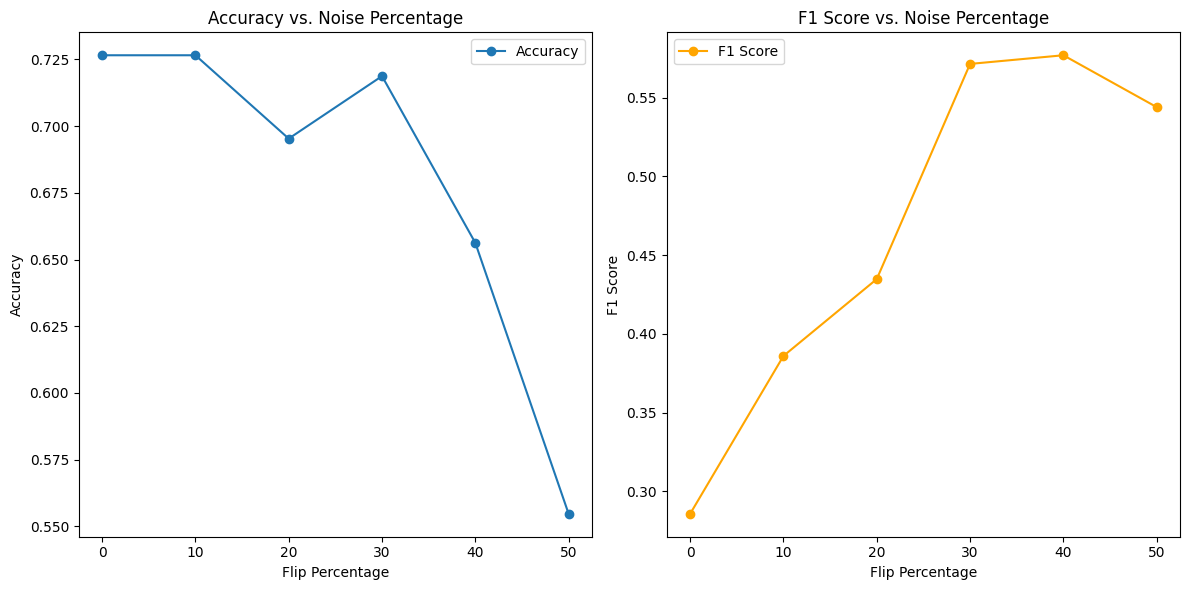

In [74]:

# Plot the accuracy and F1 scores
percentages = [0,10, 20, 30, 40, 50]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(percentages, accuracies, marker='o', label='Accuracy')
plt.xlabel('Flip Percentage')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Percentage')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(percentages, f1_scores, marker='o', label='F1 Score', color='orange')
plt.xlabel('Flip Percentage')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Noise Percentage')
plt.legend()

plt.tight_layout()
plt.show()

#### 4.2. Masking Rate = 20%

In [9]:
pretrain_base_pth = "../outputs/pretrainlocal/mask_20/mask_20.ckpt"
pretrained=transformer_autoencoder.TransformerAutoEncoder.load_from_checkpoint(pretrain_base_pth)
pretrained.eval()

TransformerAutoEncoder(
  (masker): Masker()
  (position_embedding): PositionalEmbedding(
    (position_embedding): Embedding(21, 5)
  )
  (encoder): TransformerEncoder(
    (encoder_blocks): ModuleList(
      (0-4): 5 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (feedforward): PositionwiseFeedForward(
          (linear_in): Linear(in_features=6, out_features=128, bias=True)
          (linear_out): Linear(in_features=128, out_features=6, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layernorm_attention): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (layernorm_feedforward): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): TransformerDecoder(
    (decoder_blocks): ModuleList(
      (0-2): 3 x TransformerBlock(
        (

In [12]:
# Define the device (CPU, GPU, or MPS)
device = "cpu" #torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

msk_rate = "20"   
df_data = []

for i in range(len(noised_list)):
    x_raw = tabular_dataset.TabularDataset(noised_base_pth + noise_list[i] + ".csv", name_labels, features_numerical, features_categorical)
    test_raw = tabular_dataset.TabularDataset(test_base_pth, name_labels, features_numerical, features_categorical)
    
    auc = f1 = ap = accuracy = 0
    cnt = 0
   
    train_generator = torch.utils.data.DataLoader(x_raw, batch_size=128)
    test_generator = torch.utils.data.DataLoader(test_raw, batch_size=128)
    
    # Initialize tensors on the correct device
    emb_total = torch.Tensor().to(device)
    lab_total = torch.Tensor().to(device)
    emb_total_test = torch.Tensor().to(device)
    lab_total_test = torch.Tensor().to(device)
    
    for batch in iter(train_generator):
        batch_test = next(iter(test_generator))
        cnt += 1
        
        with torch.no_grad():
            # Move tensors to the correct device
            x = batch[0].to(device)
            labels = batch[1].to(device)
            x_test = batch_test[0].to(device)
            labels_test = batch_test[1].to(device)
            
            # Obtain embeddings
            emb_per_batch = pretrained(x, 0).to(device)
            emb_per_batch = emb_per_batch.view(emb_per_batch.size(0), -1) # properly flattening

            emb_per_batch_test = pretrained(x_test, 0).to(device)
            emb_per_batch_test = emb_per_batch_test.view(emb_per_batch_test.size(0), -1)

            
            # Concatenate embeddings and labels
            emb_total = torch.cat([emb_total, emb_per_batch])
            lab_total = torch.cat([lab_total, labels])
            emb_total_test = torch.cat([emb_total_test, emb_per_batch_test])
            lab_total_test = torch.cat([lab_total_test, labels_test])
    

    # Reshape embeddings to 2D
    emb_total = emb_total.view(-1, emb_total.size(-1)).cpu().numpy()
    lab_total = lab_total.view(-1).cpu().numpy()
    emb_total_test = emb_total_test.view(-1, emb_total_test.size(-1)).cpu().numpy()
    lab_total_test = lab_total_test.view(-1).cpu().numpy()


    # Train logistic regression and evaluate
    reg = LogisticRegression().fit(emb_total, lab_total)    
    pred = reg.predict(emb_total_test)
        
    auc_batch = roc_auc_score(lab_total_test, pred)
    f1_batch = f1_score(lab_total_test, pred)
    ap_batch = average_precision_score(lab_total_test, pred)
    accuracy_batch = accuracy_score(lab_total_test, pred)
        
    auc += auc_batch
    f1 += f1_batch
    ap += ap_batch
    accuracy += accuracy_batch
        
    print("-----" + noise_list[i] + "% noise" + "-----")
    print("AUC: " + str(auc))
    print("F1: " + str(f1))
    print("AP: " + str(ap))
    print("Accuracy: " + str(accuracy))
    
    df_data.append([msk_rate, noise_list[i], auc, f1, ap, accuracy])
    
df = pd.DataFrame(df_data, columns=["Masking", "Noise", "AUC", "F1", "AP", "Accuracy"])

/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----0% noise-----
AUC: 0.5452898550724637
F1: 0.2448979591836735
AP: 0.3112980769230769
Accuracy: 0.7109375


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----10% noise-----
AUC: 0.5929951690821257
F1: 0.37931034482758624
AP: 0.3480902777777778
Accuracy: 0.71875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----20% noise-----
AUC: 0.607487922705314
F1: 0.42424242424242425
AP: 0.35335648148148147
Accuracy: 0.703125


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----30% noise-----
AUC: 0.6612318840579711
F1: 0.5185185185185186
AP: 0.38940972222222225
Accuracy: 0.6953125


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----40% noise-----
AUC: 0.7016908212560387
F1: 0.5686274509803921
AP: 0.40864372895622897
Accuracy: 0.65625
-----50% noise-----
AUC: 0.6678743961352657
F1: 0.5396825396825397
AP: 0.3724151234567901
Accuracy: 0.546875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 20%

In [13]:
df.head(10)

,Masking,Noise,AUC,F1,AP,Accuracy
0,20,0,0.545290,0.244898,0.311298,0.710938
1,20,10,0.592995,0.379310,0.348090,0.718750
2,20,20,0.607488,0.424242,0.353356,0.703125
3,20,30,0.661232,0.518519,0.389410,0.695312
4,20,40,0.701691,0.568627,0.408644,0.656250
5,20,50,0.667874,0.539683,0.372415,0.546875


In [14]:
accuracies = df.Accuracy.to_list()
f1_scores = df.F1.to_list()

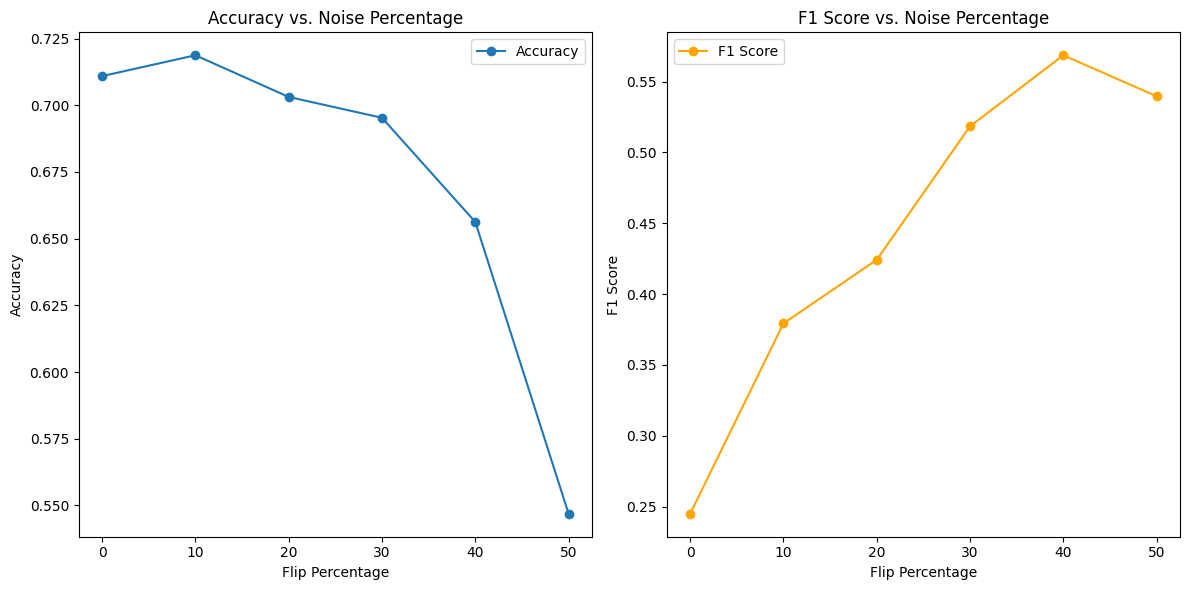

In [15]:

# Plot the accuracy and F1 scores
percentages = [0,10, 20, 30, 40, 50]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(percentages, accuracies, marker='o', label='Accuracy')
plt.xlabel('Flip Percentage')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Percentage')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(percentages, f1_scores, marker='o', label='F1 Score', color='orange')
plt.xlabel('Flip Percentage')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Noise Percentage')
plt.legend()

plt.tight_layout()
plt.show()

#### 4.3. Masking Rate = 60%

In [5]:
pretrain_base_pth = "../outputs/pretrainlocal/mask_60/epoch=58.ckpt"
pretrained=transformer_autoencoder.TransformerAutoEncoder.load_from_checkpoint(pretrain_base_pth)
pretrained.eval()

TransformerAutoEncoder(
  (masker): Masker()
  (position_embedding): PositionalEmbedding(
    (position_embedding): Embedding(21, 127)
  )
  (encoder): TransformerEncoder(
    (encoder_blocks): ModuleList(
      (0-4): 5 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (feedforward): PositionwiseFeedForward(
          (linear_in): Linear(in_features=128, out_features=128, bias=True)
          (linear_out): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layernorm_attention): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layernorm_feedforward): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): TransformerDecoder(
    (decoder_blocks): ModuleList(
      (0-2): 3 x TransformerBl

In [8]:

# Define the device (CPU, GPU, or MPS)
device = "cpu" #torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

msk_rate = "60"   
df_data = []

for i in range(len(noised_list)):
    x_raw = tabular_dataset.TabularDataset(noised_base_pth + noise_list[i] + ".csv", name_labels, features_numerical, features_categorical)
    test_raw = tabular_dataset.TabularDataset(test_base_pth, name_labels, features_numerical, features_categorical)
    
    auc = f1 = ap = accuracy = 0
    cnt = 0
   
    train_generator = torch.utils.data.DataLoader(x_raw, batch_size=128)
    test_generator = torch.utils.data.DataLoader(test_raw, batch_size=128)
    
    # Initialize tensors on the correct device
    emb_total = torch.Tensor().to(device)
    lab_total = torch.Tensor().to(device)
    emb_total_test = torch.Tensor().to(device)
    lab_total_test = torch.Tensor().to(device)
    
    for batch in iter(train_generator):
        batch_test = next(iter(test_generator))
        cnt += 1
        
        with torch.no_grad():
            # Move tensors to the correct device
            x = batch[0].to(device)
            labels = batch[1].to(device)
            x_test = batch_test[0].to(device)
            labels_test = batch_test[1].to(device)
            
            # Obtain embeddings
            emb_per_batch = pretrained(x, 0).to(device)
            emb_per_batch = emb_per_batch.view(emb_per_batch.size(0), -1) # properly flattening

            emb_per_batch_test = pretrained(x_test, 0).to(device)
            emb_per_batch_test = emb_per_batch_test.view(emb_per_batch_test.size(0), -1)

            
            # Concatenate embeddings and labels
            emb_total = torch.cat([emb_total, emb_per_batch])
            lab_total = torch.cat([lab_total, labels])
            emb_total_test = torch.cat([emb_total_test, emb_per_batch_test])
            lab_total_test = torch.cat([lab_total_test, labels_test])
    

    # Reshape embeddings to 2D
    emb_total = emb_total.view(-1, emb_total.size(-1)).cpu().numpy()
    lab_total = lab_total.view(-1).cpu().numpy()
    emb_total_test = emb_total_test.view(-1, emb_total_test.size(-1)).cpu().numpy()
    lab_total_test = lab_total_test.view(-1).cpu().numpy()


    # Train logistic regression and evaluate
    reg = LogisticRegression().fit(emb_total, lab_total)    
    pred = reg.predict(emb_total_test)
        
    auc_batch = roc_auc_score(lab_total_test, pred)
    f1_batch = f1_score(lab_total_test, pred)
    ap_batch = average_precision_score(lab_total_test, pred)
    accuracy_batch = accuracy_score(lab_total_test, pred)
        
    auc += auc_batch
    f1 += f1_batch
    ap += ap_batch
    accuracy += accuracy_batch
        
    print("-----" + noise_list[i] + "% noise" + "-----")
    print("AUC: " + str(auc))
    print("F1: " + str(f1))
    print("AP: " + str(ap))
    print("Accuracy: " + str(accuracy))
    
    df_data.append([msk_rate, noise_list[i], auc, f1, ap, accuracy])
    
df = pd.DataFrame(df_data, columns=["Masking", "Noise", "AUC", "F1", "AP", "Accuracy"])

/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----0% noise-----
AUC: 0.5452898550724637
F1: 0.2448979591836735
AP: 0.3112980769230769
Accuracy: 0.7109375


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----10% noise-----
AUC: 0.5984299516908212
F1: 0.3859649122807018
AP: 0.3553654100529101
Accuracy: 0.7265625


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----20% noise-----
AUC: 0.621376811594203
F1: 0.44776119402985076
AP: 0.36567540322580644
Accuracy: 0.7109375


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----30% noise-----
AUC: 0.7028985507246377
F1: 0.5714285714285715
AP: 0.4270833333333333
Accuracy: 0.71875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----40% noise-----
AUC: 0.696256038647343
F1: 0.5631067961165048
AP: 0.4033608001658375
Accuracy: 0.6484375
-----50% noise-----
AUC: 0.6594202898550724
F1: 0.5322580645161291
AP: 0.3671875
Accuracy: 0.546875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 60%

In [9]:
df.head(10)

,Masking,Noise,AUC,F1,AP,Accuracy
0,60,0,0.545290,0.244898,0.311298,0.710938
1,60,10,0.598430,0.385965,0.355365,0.726562
2,60,20,0.621377,0.447761,0.365675,0.710938
3,60,30,0.702899,0.571429,0.427083,0.718750
4,60,40,0.696256,0.563107,0.403361,0.648438
5,60,50,0.659420,0.532258,0.367188,0.546875


In [10]:
accuracies = df.Accuracy.to_list()
f1_scores = df.F1.to_list()

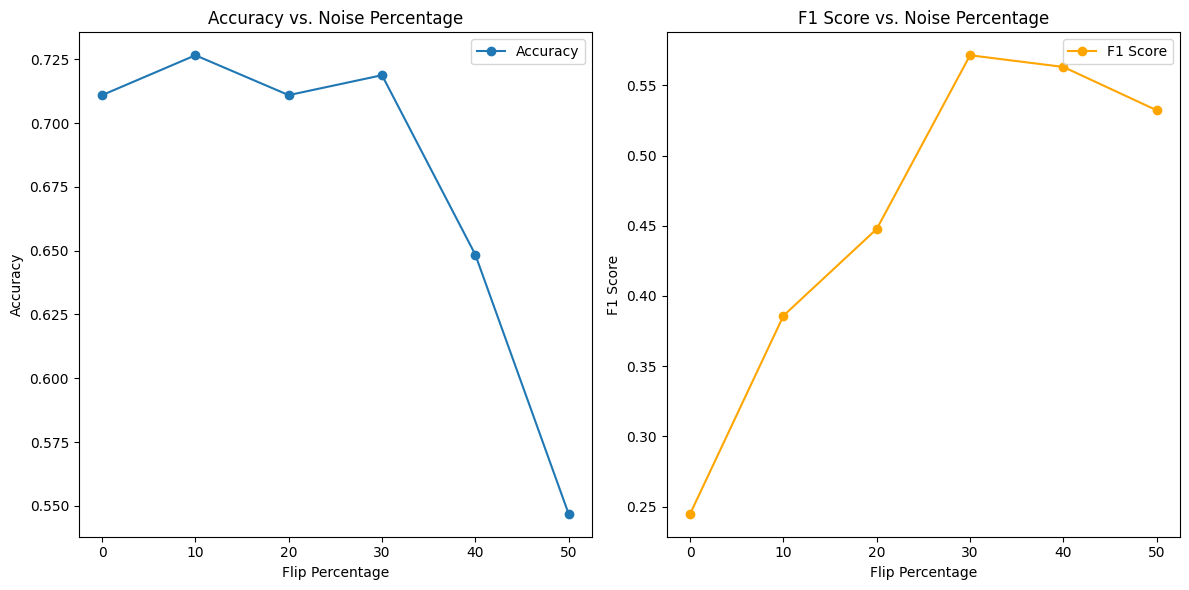

In [11]:
# Plot the accuracy and F1 scores
percentages = [0,10, 20, 30, 40, 50]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(percentages, accuracies, marker='o', label='Accuracy')
plt.xlabel('Flip Percentage')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Percentage')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(percentages, f1_scores, marker='o', label='F1 Score', color='orange')
plt.xlabel('Flip Percentage')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Noise Percentage')
plt.legend()

plt.tight_layout()
plt.show()

#### 4.4. Masking Rate = 40%

In [5]:
pretrain_base_pth = "../outputs/pretrainlocal/mask_40/epoch=58.ckpt"
pretrained=transformer_autoencoder.TransformerAutoEncoder.load_from_checkpoint(pretrain_base_pth)
pretrained.eval()

TransformerAutoEncoder(
  (masker): Masker()
  (position_embedding): PositionalEmbedding(
    (position_embedding): Embedding(21, 127)
  )
  (encoder): TransformerEncoder(
    (encoder_blocks): ModuleList(
      (0-4): 5 x TransformerBlock(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (feedforward): PositionwiseFeedForward(
          (linear_in): Linear(in_features=128, out_features=128, bias=True)
          (linear_out): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layernorm_attention): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layernorm_feedforward): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): TransformerDecoder(
    (decoder_blocks): ModuleList(
      (0-2): 3 x TransformerBl

In [6]:

# Define the device (CPU, GPU, or MPS)
device = "cpu" #torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

msk_rate = "40"   
df_data = []

for i in range(len(noised_list)):
    x_raw = tabular_dataset.TabularDataset(noised_base_pth + noise_list[i] + ".csv", name_labels, features_numerical, features_categorical)
    test_raw = tabular_dataset.TabularDataset(test_base_pth, name_labels, features_numerical, features_categorical)
    
    auc = f1 = ap = accuracy = 0
    cnt = 0
   
    train_generator = torch.utils.data.DataLoader(x_raw, batch_size=128)
    test_generator = torch.utils.data.DataLoader(test_raw, batch_size=128)
    
    # Initialize tensors on the correct device
    emb_total = torch.Tensor().to(device)
    lab_total = torch.Tensor().to(device)
    emb_total_test = torch.Tensor().to(device)
    lab_total_test = torch.Tensor().to(device)
    
    for batch in iter(train_generator):
        batch_test = next(iter(test_generator))
        cnt += 1
        
        with torch.no_grad():
            # Move tensors to the correct device
            x = batch[0].to(device)
            labels = batch[1].to(device)
            x_test = batch_test[0].to(device)
            labels_test = batch_test[1].to(device)
            
            # Obtain embeddings
            emb_per_batch = pretrained(x, 0).to(device)
            emb_per_batch = emb_per_batch.view(emb_per_batch.size(0), -1) # properly flattening

            emb_per_batch_test = pretrained(x_test, 0).to(device)
            emb_per_batch_test = emb_per_batch_test.view(emb_per_batch_test.size(0), -1)

            
            # Concatenate embeddings and labels
            emb_total = torch.cat([emb_total, emb_per_batch])
            lab_total = torch.cat([lab_total, labels])
            emb_total_test = torch.cat([emb_total_test, emb_per_batch_test])
            lab_total_test = torch.cat([lab_total_test, labels_test])
    

    # Reshape embeddings to 2D
    emb_total = emb_total.view(-1, emb_total.size(-1)).cpu().numpy()
    lab_total = lab_total.view(-1).cpu().numpy()
    emb_total_test = emb_total_test.view(-1, emb_total_test.size(-1)).cpu().numpy()
    lab_total_test = lab_total_test.view(-1).cpu().numpy()


    # Train logistic regression and evaluate
    reg = LogisticRegression().fit(emb_total, lab_total)    
    pred = reg.predict(emb_total_test)
        
    auc_batch = roc_auc_score(lab_total_test, pred)
    f1_batch = f1_score(lab_total_test, pred)
    ap_batch = average_precision_score(lab_total_test, pred)
    accuracy_batch = accuracy_score(lab_total_test, pred)
        
    auc += auc_batch
    f1 += f1_batch
    ap += ap_batch
    accuracy += accuracy_batch
        
    print("-----" + noise_list[i] + "% noise" + "-----")
    print("AUC: " + str(auc))
    print("F1: " + str(f1))
    print("AP: " + str(ap))
    print("Accuracy: " + str(accuracy))
    
    df_data.append([msk_rate, noise_list[i], auc, f1, ap, accuracy])
    
df = pd.DataFrame(df_data, columns=["Masking", "Noise", "AUC", "F1", "AP", "Accuracy"])

/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----0% noise-----
AUC: 0.5591787439613526
F1: 0.28
AP: 0.3237847222222222
Accuracy: 0.71875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----10% noise-----
AUC: 0.5821256038647343
F1: 0.3666666666666667
AP: 0.3353587962962963
Accuracy: 0.703125


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----20% noise-----
AUC: 0.6219806763285025
F1: 0.4594594594594595
AP: 0.3596948099415205
Accuracy: 0.6875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----30% noise-----
AUC: 0.711352657004831
F1: 0.5813953488372093
AP: 0.4331597222222222
Accuracy: 0.71875


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----40% noise-----
AUC: 0.696256038647343
F1: 0.5631067961165048
AP: 0.4033608001658375
Accuracy: 0.6484375
-----50% noise-----
AUC: 0.6515700483091788
F1: 0.5271317829457365
AP: 0.36090576463560337
Accuracy: 0.5234375


/Users/A117870943/anaconda3/envs/telco_ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 40%

In [7]:
df.head(10)

,Masking,Noise,AUC,F1,AP,Accuracy
0,40,0,0.559179,0.280000,0.323785,0.718750
1,40,10,0.582126,0.366667,0.335359,0.703125
2,40,20,0.621981,0.459459,0.359695,0.687500
3,40,30,0.711353,0.581395,0.433160,0.718750
4,40,40,0.696256,0.563107,0.403361,0.648438
5,40,50,0.651570,0.527132,0.360906,0.523438


In [8]:
accuracies = df.Accuracy.to_list()
f1_scores = df.F1.to_list()

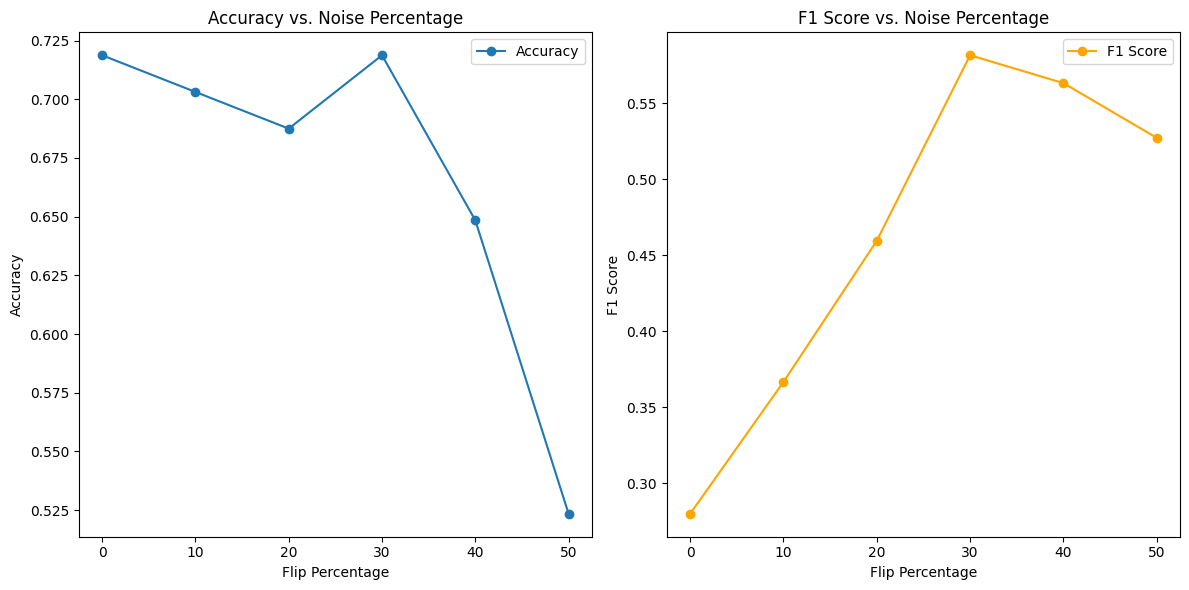

In [9]:
# Plot the accuracy and F1 scores
percentages = [0,10, 20, 30, 40, 50]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(percentages, accuracies, marker='o', label='Accuracy')
plt.xlabel('Flip Percentage')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Percentage')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(percentages, f1_scores, marker='o', label='F1 Score', color='orange')
plt.xlabel('Flip Percentage')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Noise Percentage')
plt.legend()

plt.tight_layout()
plt.show()